In [1]:
!pip install -q efficientnet


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/flower-classification-with-tpus/sample_submission.csv
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-512x512/val/05-512x512-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-512x512/val/11-512x512-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-512x512/val/09-512x512-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-512x512/val/07-512x512-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-512x512/val/03-512x512-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-512x512/val/12-512x512-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-512x512/val/13-512x512-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-512x512/val/15-512x512-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-512x512/val/02-512x512-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-512x512/val/10-512x512-23

In [3]:
import math, re, os
import tensorflow as tf
import numpy as np

import efficientnet.tfkeras as efn

from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.1.0


In [4]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


## Competition data access

TPUs read data directly from Google Cloud Storage (GCS). This Kaggle utility will copy the dataset to a GCS bucket co-located with the TPU. If you have multiple datasets attached to the notebook, you** can pass the name of a specific dataset to the get_gcs_path function. The name of the dataset is the name of the directory it is mounted in. Use !ls /kaggle/input/ to list attached datasets.

In [5]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('flower-classification-with-tpus') # you can list the bucket with "!gsutil ls $GCS_DS_PATH"


## Configuration

In [6]:
IMAGE_SIZE = [512, 512] # At this size, a GPU will run out of memory. Use the TPU.
                        # For GPU training, please select 224 x 224 px image size.
EPOCHS = 25
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]
print(GCS_PATH)
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

gs://kds-b2e6cdbc4af76dcf0363776c09c12fe46872cab211d1de9f60ec7aec/tfrecords-jpeg-512x512


In [7]:
# using validation set for training to inch out last marginal performance improvement
VALIDATION = True
if not VALIDATION:
    TRAINING_FILENAMES = TRAINING_FILENAMES+VALIDATION_FILENAMES

## Visualization utilities
data -> pixels, nothing of much interest for the machine learning practitioner in this section.

In [8]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

## Datasets

In [9]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_contrast(image,0,1)
    image = tf.image.random_saturation(image,0,1)
    #image = tf.image.random_hue(image, 0.2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_train_valid_datasets():
    dataset = load_dataset(TRAINING_FILENAMES + VALIDATION_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


Learning rate schedule: 1e-05 to 0.0004 to 1.56e-05


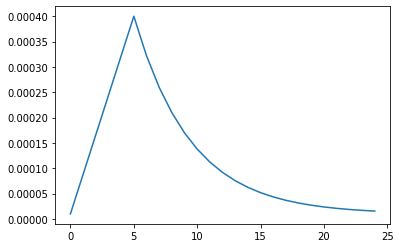

In [10]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.
def lrfn(epoch):
    LR_START = 0.00001
    LR_MAX = 0.00005 * strategy.num_replicas_in_sync
    LR_MIN = 0.00001
    LR_RAMPUP_EPOCHS = 5
    LR_SUSTAIN_EPOCHS = 0
    LR_EXP_DECAY = .8
    
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [11]:
# data dump
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("Test data shapes:")
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Training data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Training data label examples: [ 70 102  48 ...  70  70  73]
Validation data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Validation data label examples: [103  62  67 ...   4  82  24]
Test data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Test data IDs: ['e72c5d3a9' 'a8a8b4261' '83f7c30e9' ... '07d138d01' 'c33ac1a9e' 'e5eca71e3']


In [12]:
# Peek at training data
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

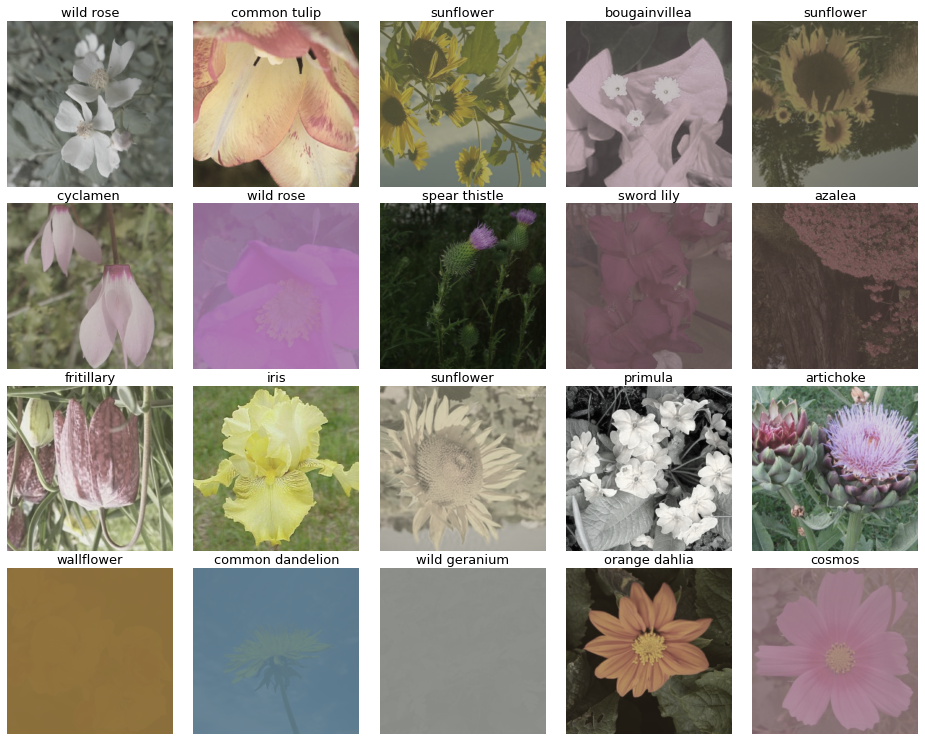

In [13]:
# run this cell again for next set of images
display_batch_of_images(next(train_batch))

In [14]:
# peer at test data
test_dataset = get_test_dataset()
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)

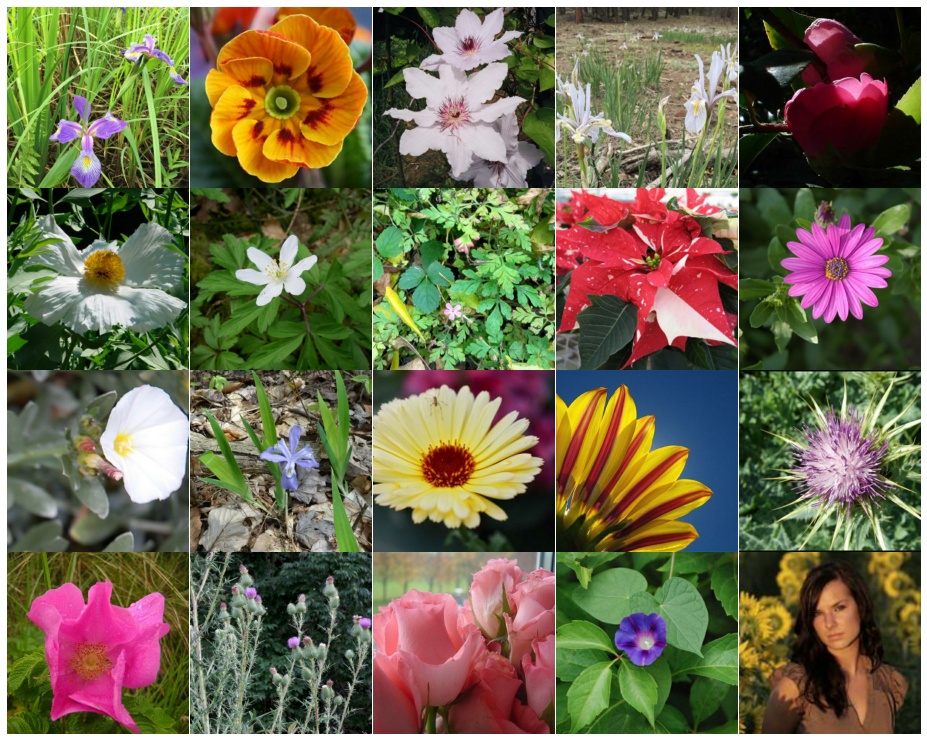

In [15]:
# run this cell again for next set of images
display_batch_of_images(next(test_batch))

## Model

In [16]:
## Model 1 DenseNet
with strategy.scope():
    dn201 = tf.keras.applications.Xception(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    dn201.trainable = True # Full Training
    
    model1 = tf.keras.Sequential([
        dn201,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

model1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model1.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 16, 16, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               213096    
Total params: 21,074,576
Trainable params: 21,020,048
Non-trainable params: 54,528
_________________________________________________________________


In [17]:
## Model 2 EfficientNet
with strategy.scope():
    enb7 = efn.EfficientNetB7(weights='noisy-student', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    enb7.trainable = True # Full Training
    
    model2 = tf.keras.Sequential([
        enb7,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
        
    ])
        
model2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model2.summary()

258072576/258068648 [==============================] - 4s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 16, 16, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 104)               266344    
Total params: 64,364,024
Trainable params: 64,053,304
Non-trainable params: 310,720
_________________________________________________________________


In [18]:
# with strategy.scope():
#     #pretrained_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#     #pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#     #pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])

#     #pretrained_model.trainable = False # False = transfer learning, True = fine-tuning
#     pretrained_model = efn.EfficientNetB7(input_shape=(512, 512, 3),weights='noisy-student',include_top=False)
#     pretrained_model.trainable = True
    
#     model = tf.keras.Sequential([
#         pretrained_model,
#         tf.keras.layers.GlobalAveragePooling2D(),
#         tf.keras.layers.Dense(len(CLASSES), activation='softmax')
#     ])


# # # load json and create model
# # from tensorflow.keras.models import load_model
# # json_file = open('/kaggle/input/models/modelVgg16_Epochs80.json', 'r')
# # loaded_model_json = json_file.read()
# # json_file.close()
# # model = load_model(loaded_model_json)
# # # load weights into new model
# # model.load_weights("/kaggle/input/models/modelVgg16_Epochs80.h5")
# # print("Loaded model from disk")

# model.compile(
#     optimizer='adam',
#     loss = 'sparse_categorical_crossentropy',
#     metrics=['sparse_categorical_accuracy']
# )
# model.summary()

## Training 

In [19]:
%%time
if VALIDATION:
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
    es_callback = tf.keras.callbacks.EarlyStopping(min_delta=0, patience=10, verbose=1, mode='auto', restore_best_weights=True)
    history1 = model1.fit(get_training_dataset(), 
                          steps_per_epoch=STEPS_PER_EPOCH, 
                          epochs=25, 
                          validation_data=get_validation_dataset(), 
                          callbacks = [lr_schedule, es_callback])
else:
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
    history1 = model1.fit(get_training_dataset(),
                          steps_per_epoch=STEPS_PER_EPOCH,
                          epochs=25, callbacks = [lr_schedule])
    

Train for 99 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/25
99/99 [==============================] - 113s 1s/step - loss: 4.4922 - sparse_categorical_accuracy: 0.0587 - val_loss: 4.2244 - val_sparse_categorical_accuracy: 0.1422

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/25
99/99 [==============================] - 30s 308ms/step - loss: 2.8568 - sparse_categorical_accuracy: 0.4148 - val_loss: 1.6843 - val_sparse_categorical_accuracy: 0.6228

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/25
99/99 [==============================] - 35s 356ms/step - loss: 1.2372 - sparse_categorical_accuracy: 0.7380 - val_loss: 0.6082 - val_sparse_categorical_accuracy: 0.8254

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/25
99/99 [==============================] - 30s 301ms/step - loss: 0.6424 - sparse_categorical_accuracy: 0.8409 - val_loss: 0.4488 - val_sparse_cate

## Visaulizing the results of the training Model 1 DenseNet 201
****

In [20]:
acc = history1.history['sparse_categorical_accuracy']

if VALIDATION:
    val_acc = history1.history['val_sparse_categorical_accuracy']

loss = history1.history['loss']

if VALIDATION:
    val_loss = history1.history['val_loss']

epochs_range = range(EPOCHS)


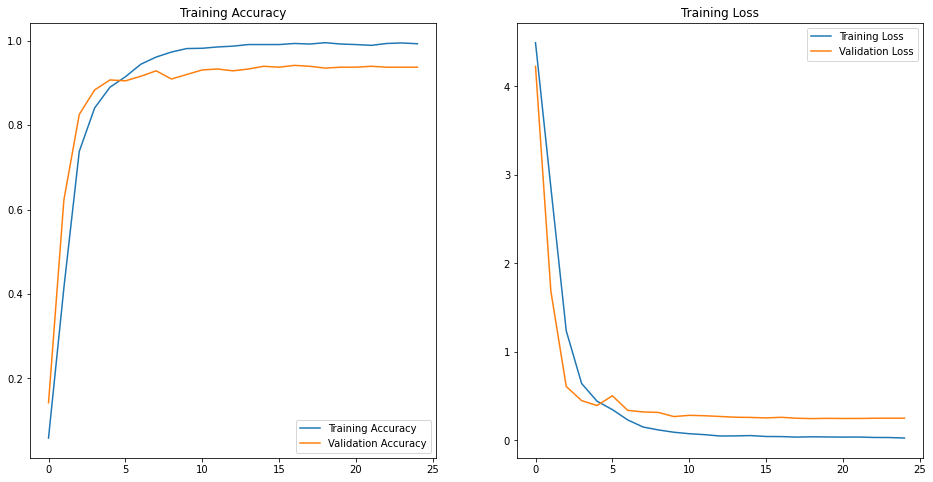

In [21]:
plt.figure(figsize=(16, 8))
# figure 1 Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
if VALIDATION:
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

# figure 2 Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
if VALIDATION:
    plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
#plt.savefig('./foo.png')
plt.show()

In [22]:
%%time
if VALIDATION:
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
    es_callback = tf.keras.callbacks.EarlyStopping(min_delta=0, patience=10, verbose=1, mode='auto', restore_best_weights=True)
    history2 = model2.fit(get_training_dataset(),
                          steps_per_epoch=STEPS_PER_EPOCH, 
                          epochs=25, validation_data=get_validation_dataset(), 
                          callbacks = [lr_schedule, es_callback])
else:
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
    history2 = model2.fit(get_training_dataset(), 
                          steps_per_epoch=STEPS_PER_EPOCH, 
                          epochs=25, callbacks = [lr_schedule])  

Train for 99 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/25
99/99 [==============================] - 430s 4s/step - loss: 4.5972 - sparse_categorical_accuracy: 0.0303 - val_loss: 4.5997 - val_sparse_categorical_accuracy: 0.0431

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/25
99/99 [==============================] - 114s 1s/step - loss: 3.6257 - sparse_categorical_accuracy: 0.2525 - val_loss: 2.5611 - val_sparse_categorical_accuracy: 0.4612

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/25
99/99 [==============================] - 106s 1s/step - loss: 1.8250 - sparse_categorical_accuracy: 0.5846 - val_loss: 0.7037 - val_sparse_categorical_accuracy: 0.8276

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/25
99/99 [==============================] - 109s 1s/step - loss: 0.8837 - sparse_categorical_accuracy: 0.7841 - val_loss: 0.3866 - val_sparse_categorica

In [23]:
# %%time
# # scheduler = tf.keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)
# if VALIDATION:
#     lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
#     es_callback = tf.keras.callbacks.EarlyStopping(min_delta=0, patience=10, verbose=1, mode='auto', restore_best_weights=True)
#     history = model.fit(get_training_dataset(),
#                         #steps_per_epoch= int(np.ceil(NUM_TRAINING_IMAGES / float(BATCH_SIZE))),
#                         #get_train_valid_datasets(), 
#                         steps_per_epoch=STEPS_PER_EPOCH,
#                         epochs= EPOCHS,
#                         validation_data = get_validation_dataset(),
#                         #validation_steps= int(np.ceil(NUM_VALIDATION_IMAGES/ float(BATCH_SIZE)))
#                         callbacks=[lr_schedule, es_callback]
#                     )
# else:
#     lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
#     es_callback = tf.keras.callbacks.EarlyStopping(min_delta=0, patience=10, verbose=1, mode='auto', restore_best_weights=True)
#     history = model.fit(#get_training_dataset(),
#                     #steps_per_epoch= int(np.ceil(NUM_TRAINING_IMAGES / float(BATCH_SIZE))),
#                     get_train_valid_datasets(), 
#                     steps_per_epoch=STEPS_PER_EPOCH,
#                     epochs= EPOCHS,
#                     #validation_data = get_validation_dataset(),
#                     #validation_steps= int(np.ceil(NUM_VALIDATION_IMAGES/ float(BATCH_SIZE)))
#                     callbacks=[lr_schedule, es_callback]
#                 )
    
    

In [24]:
# history = model.fit(get_training_dataset(), 
#                     steps_per_epoch=STEPS_PER_EPOCH, 
#                     epochs=EPOCHS, 
#                     validation_data=get_validation_dataset())

## Visaulizing the results of the training Model 2 EfficientNet
****

In [25]:
acc = history2.history['sparse_categorical_accuracy']

if VALIDATION:
    val_acc = history2.history['val_sparse_categorical_accuracy']

loss = history2.history['loss']

if VALIDATION:
    val_loss = history2.history['val_loss']

epochs_range = range(EPOCHS)


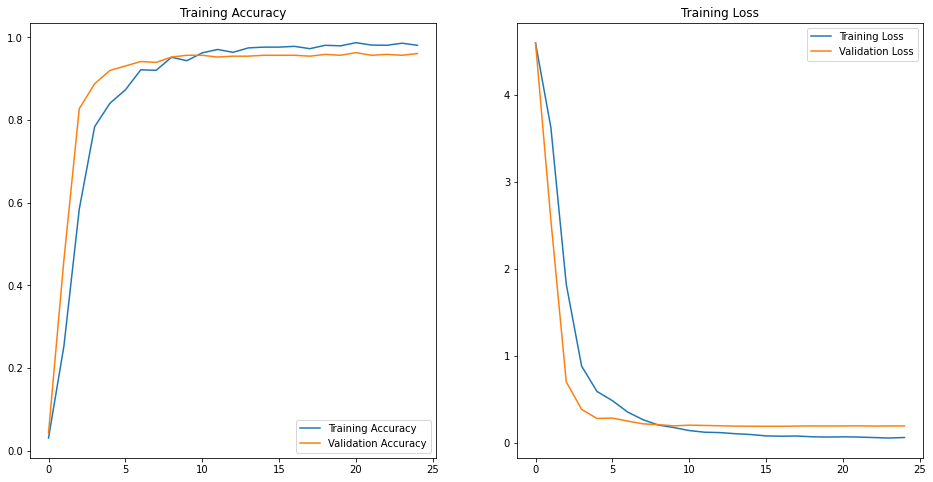

In [26]:
plt.figure(figsize=(16, 8))
# figure 1 Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
if VALIDATION:
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

# figure 2 Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
if VALIDATION:
    plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
#plt.savefig('./foo.png')
plt.show()


In [27]:
# display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
# display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

## Confusion Matrix

In [28]:
if VALIDATION:
    cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
    images_ds = cmdataset.map(lambda image, label: image)
    labels_ds = cmdataset.map(lambda image, label: label).unbatch()
    cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
    cm_probabilities = (model1.predict(images_ds)*.6)+(model2.predict(images_ds)*0.4)
    #cm_probabilities = model.predict(images_ds)
    cm_predictions = np.argmax(cm_probabilities, axis=-1)
    print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
    print("Predicted labels: ", cm_predictions.shape, cm_predictions)

Correct   labels:  (3712,) [ 50  13  74 ... 102  48  67]
Predicted labels:  (3712,) [ 50  13  74 ... 102  48  67]


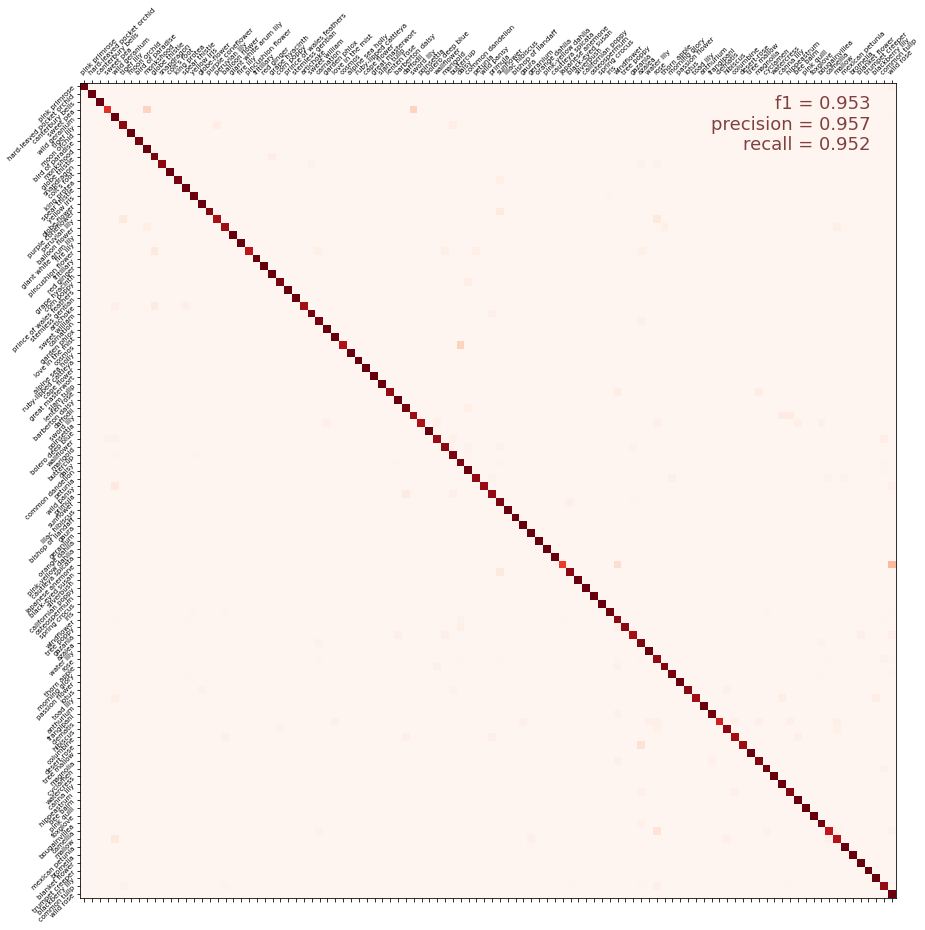

f1 score: 0.95286, precision: 0.95680, recall: 0.95200


In [29]:
if VALIDATION:
    cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
    score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
    display_confusion_matrix(cmat, score, precision, recall)
    print('f1 score: {:.5f}, precision: {:.5f}, recall: {:.5f}'.format(score, precision, recall))

## Predictions

In [30]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
# probabilities = model.predict(test_images_ds)
probabilities = (model1.predict(test_images_ds)*0.3)+model2.predict(test_images_ds)*0.7
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
!head submission.csv





Computing predictions...
[ 67  28  83 ... 103 102  62]
Generating submission.csv file...
id,label
252d840db,67
1c4736dea,28
c37a6f3e9,83
00e4f514e,103
59d1b6146,46
8d808a07b,53
aeb67eefb,52
53cfc6586,29
aaa580243,82


## Visual validation

In [31]:
if VALIDATION:
    dataset = get_validation_dataset()
    dataset = dataset.unbatch().batch(20)
    batch = iter(dataset)

In [32]:
# run this cell again for next set of images
if VALIDATION:
    images, labels = next(batch)
    probabilities = model.predict(images)
    predictions = np.argmax(probabilities, axis=-1)
    display_batch_of_images((images, labels), predictions)

NameError: name 'model' is not defined

In [33]:
model1.save('Xception_30epochs.h5')
model2.save('efnb7_30epochs.h5')